In [1]:
repo_root = "/Users/miskodzamba/Dropbox/research/gits/spf/"
import sys

if repo_root not in sys.path:
    sys.path.append(repo_root)  # go to parent dir

In [2]:
from torch.utils.data import Dataset
import yaml
import torch
from spf.rf import precompute_steering_vectors
from spf.utils import zarr_open_from_lmdb_store
from spf.dataset.v5_data import v5rx_f64_keys, v5rx_2xf64_keys
import numpy as np
from spf.rf import speed_of_light
from multiprocessing.pool import ThreadPool
import os
import pickle
from multiprocessing import Pool
import time
import tqdm

#         return pickle.load(open(results_fn, "rb"))

In [3]:
from spf.dataset.spf_dataset import v5spfdataset


ds = v5spfdataset(
    # "/Volumes/SPFData/missions/april5/wallarrayv3_2024_04_05_22_13_07_nRX2_rx_circle"
    # "/Volumes/SPFData/missions/april5/wallarrayv3_2024_05_10_05_03_21_nRX2_rx_circle_tag_rand10_90_rand30_100"
    # "/Volumes/SPFData/missions/april5/wallarrayv3_2024_04_10_05_08_55_nRX2_rx_circle"
    "/Volumes/SPFData/missions/april5/wallarrayv3_2024_05_06_19_04_15_nRX2_bounce",
    nthetas=11,
)

In [4]:
session_idx = 150 * 2

/Users/miskodzamba/Dropbox/research/gits/spf/spf/rf.py:723: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(complex128, 2, 'C', False, aligned=True), Array(complex128, 2, 'A', False, aligned=True))
  phase_adjusted = np.dot(


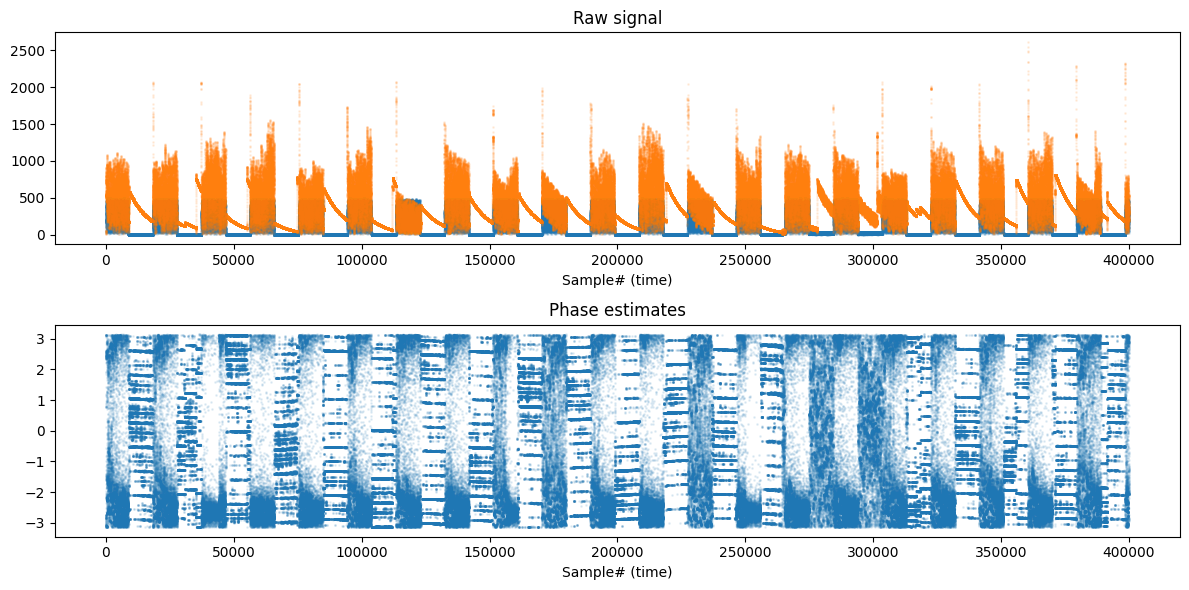

In [5]:
from spf.rf import beamformer_given_steering_nomean, get_phase_diff, simple_segment
import matplotlib.pyplot as plt

data = ds[session_idx]
# signal_matrix = load_zarr_to_numpy(z.receivers["r0"].signal_matrix[session_idx])
n = 2 * 4 * 50000
offset = 0
v = data["signal_matrix"][:, offset : offset + n].numpy()
pd = get_phase_diff(v)

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

axs[0].scatter(np.arange(n), np.abs(v[0]), alpha=0.1, s=1)
axs[0].scatter(np.arange(n), np.abs(v[1]), alpha=0.1, s=1)
axs[0].set_title("Raw signal")
axs[0].set_xlabel("Sample# (time)")
axs[1].set_xlabel("Sample# (time)")
axs[1].set_title("Phase estimates")
axs[1].scatter(np.arange(n), pd, s=1, alpha=0.1)

beam_sds = [
    beamformer_given_steering_nomean(
        steering_vectors=ds.steering_vectors[receiver_idx],
        signal_matrix=v,
    )
    for receiver_idx in range(2)
]

window_sds = []
for window in simple_segment(
    v,
    window_size=2500,
    stride=2500,
    trim=20,
    mean_diff_threshold=0.2,  #
    max_stddev_threshold=0.5,  # just eyeballed this
    drop_less_than_size=3000,
    min_abs_signal=40,
)["simple_segmentation"]:
    if window["type"] == "signal":
        axs[1].plot(
            [window["start_idx"], window["end_idx"]],
            [window["mean"], window["mean"]],
            color="red",
        )
    else:
        axs[1].plot(
            [window["start_idx"], window["end_idx"]],
            [window["mean"], window["mean"]],
            color="orange",
        )
    # print(window["start_idx"], window["end_idx"])
    _beam_sds = beam_sds[0][:, window["start_idx"] : window["end_idx"]].mean(axis=1)
    # _beam_sds = _beam_sds.mean(axis=1)
    # _beam_sds -= _beam_sds.min()
    window_sds.append(_beam_sds)
window_sds = np.array(window_sds)
fig.set_tight_layout(True)

/var/folders/31/j84vsqkx1rg7zggf_0glkq8m0000gn/T/ipykernel_84582/2344542798.py:6: RuntimeWarning: Mean of empty slice.
  np.array([x["mean"] for x in result["simple_segmentation"]]).mean()
/Users/miskodzamba/.virtualenvs/spf/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Mean phase diff of seg. chunk')

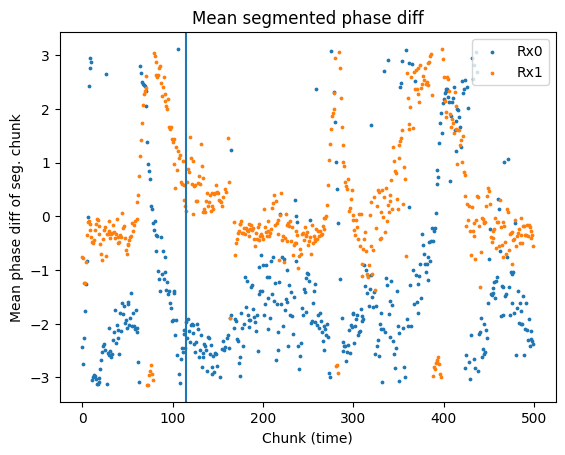

In [6]:
segmentation = ds.get_segmentation()
mean_phase_results = {}
for receiver, results in segmentation["segmentation_by_receiver"].items():
    mean_phase_results[receiver] = np.array(
        [
            np.array([x["mean"] for x in result["simple_segmentation"]]).mean()
            for result in results
        ]
    )


first_n = 250 * 2
fig, axs = plt.subplots(1, 1)
axs.scatter(range(first_n), mean_phase_results["r0"][:first_n], s=3, label="Rx0")
axs.scatter(range(first_n), mean_phase_results["r1"][:first_n], s=3, label="Rx1")
axs.legend()
axs.axvline(x=115)
axs.set_title("Mean segmented phase diff")
axs.set_xlabel("Chunk (time)")
axs.set_ylabel("Mean phase diff of seg. chunk")

In [7]:
# segmentation_by_receiver.keys()

In [8]:
ds.get_segmentation_mean_phase()
ds.get_estimated_thetas()

/Users/miskodzamba/Dropbox/research/gits/spf/spf/dataset/spf_dataset.py:284: RuntimeWarning: Mean of empty slice.
  np.array([x["mean"] for x in result["simple_segmentation"]]).mean()


{'r0': (array([ 1.24635838,  1.57065491,  1.08002537, ..., -0.47437551,
         -0.94849232, -0.90047342]),
  array([1.89523428, 1.57093775, 2.06156728, ..., 3.61596816, 4.09008498,
         4.04206607]),
  array([-1.57079633, -1.57079633, -1.57079633, ..., -4.71238898,
         -4.71238898, -4.71238898])),
 'r1': (array([ 0.30021391,  0.30419706,  0.50770882, ...,  1.57065491,
         -1.57065491, -1.57065491]),
  array([2.84137875, 2.8373956 , 2.63388384, ..., 1.57093775, 4.71224756,
         4.71224756]),
  array([-1.57079633, -1.57079633, -1.57079633, ..., -1.57079633,
         -4.71238898, -4.71238898]))}

/Users/miskodzamba/Dropbox/research/gits/spf/spf/dataset/spf_dataset.py:284: RuntimeWarning: Mean of empty slice.
  np.array([x["mean"] for x in result["simple_segmentation"]]).mean()
/Users/miskodzamba/.virtualenvs/spf/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


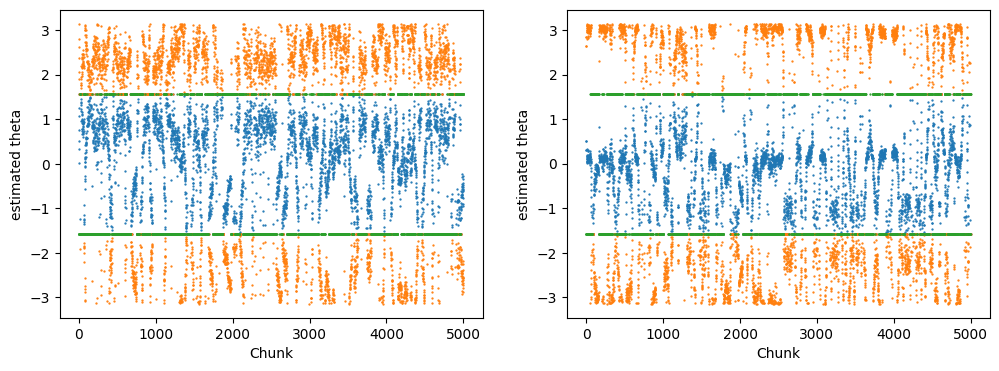

In [9]:
from spf.dataset.spf_dataset import pi_norm
from spf.rf import c as speed_of_light


fig, axs = plt.subplots(1, 2, figsize=(12, 4))

estimated_thetas = ds.get_estimated_thetas()
for rx_idx in [0, 1]:

    axs[rx_idx].scatter(
        range(estimated_thetas[f"r{rx_idx}"][0].shape[0]),
        pi_norm(estimated_thetas[f"r{rx_idx}"][0]),
        s=0.4,
    )
    axs[rx_idx].scatter(
        range(estimated_thetas[f"r{rx_idx}"][1].shape[0]),
        pi_norm(estimated_thetas[f"r{rx_idx}"][1]),
        s=0.4,
    )
    axs[rx_idx].scatter(
        range(estimated_thetas[f"r{rx_idx}"][2].shape[0]),
        pi_norm(estimated_thetas[f"r{rx_idx}"][2]),
        s=0.4,
    )
    axs[rx_idx].set_xlabel("Chunk")
    axs[rx_idx].set_ylabel("estimated theta")

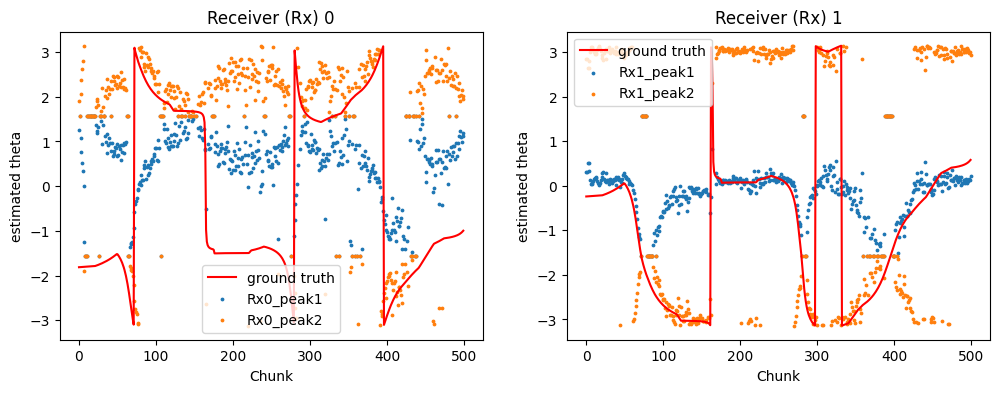

In [10]:
from spf.dataset.spf_dataset import pi_norm


fig, axs = plt.subplots(1, 2, figsize=(12, 4))

first_n = 250 * 2
estimated_thetas = ds.get_estimated_thetas()
for rx_idx in [0, 1]:
    expected_theta = ds.ground_truth_thetas[rx_idx]
    axs[rx_idx].plot(
        expected_theta[:first_n], alpha=1, color="red", label="ground truth"
    )

    n = estimated_thetas[f"r{rx_idx}"][0].shape[0]
    axs[rx_idx].scatter(
        range(first_n),
        pi_norm(estimated_thetas[f"r{rx_idx}"][0])[:first_n],
        s=3,
        label=f"Rx{rx_idx}_peak1",
    )
    axs[rx_idx].scatter(
        range(first_n),
        pi_norm(estimated_thetas[f"r{rx_idx}"][1])[:first_n],
        s=3,
        label=f"Rx{rx_idx}_peak2",
    )
    axs[rx_idx].set_xlabel("Chunk")
    axs[rx_idx].set_ylabel("estimated theta")
    axs[rx_idx].legend()
    axs[rx_idx].set_title(f"Receiver (Rx) {rx_idx}")

loss,█▅▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.16707


ALL (256, 3)
0.3528231680393219
0.03874407708644867
0.018505411222577095
0.008912267163395882
0.004591775126755238
0.0022981781512498856
0.0011142141884192824
0.0005373197491280735
0.0002627945505082607
0.00012862784205935895


loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,7e-05


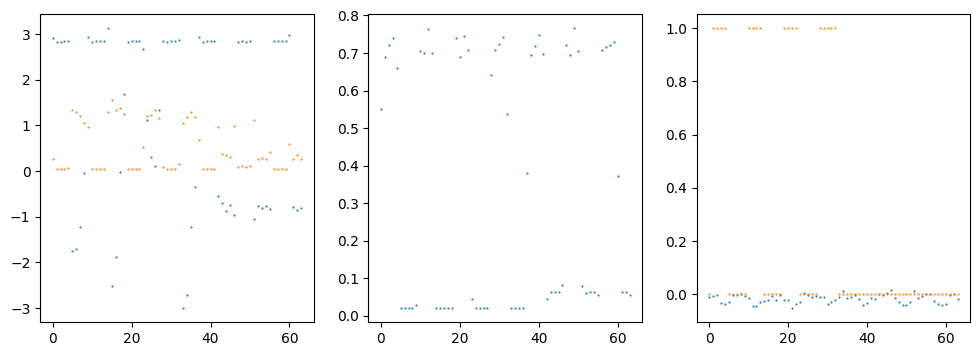

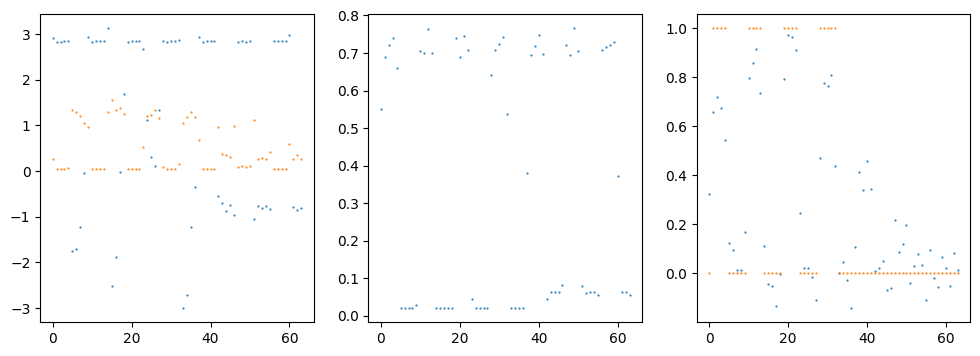

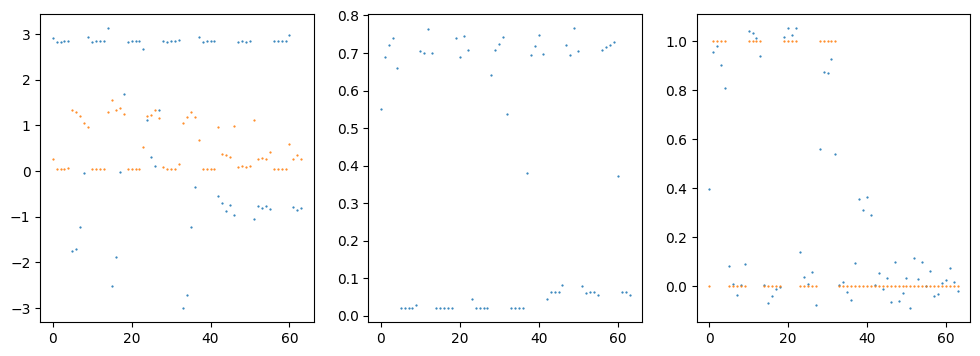

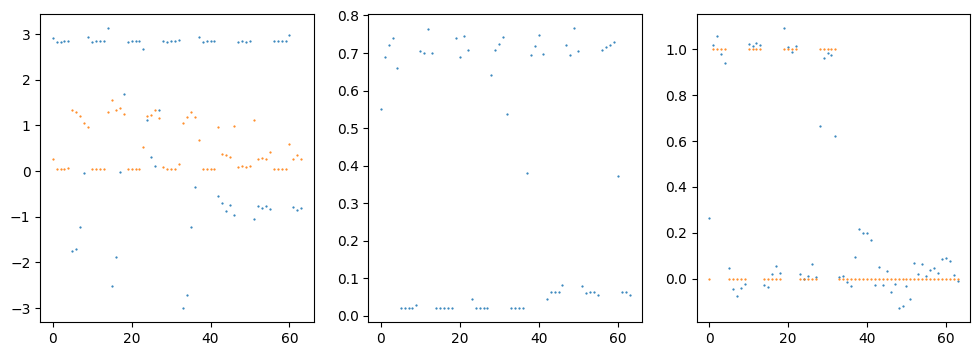

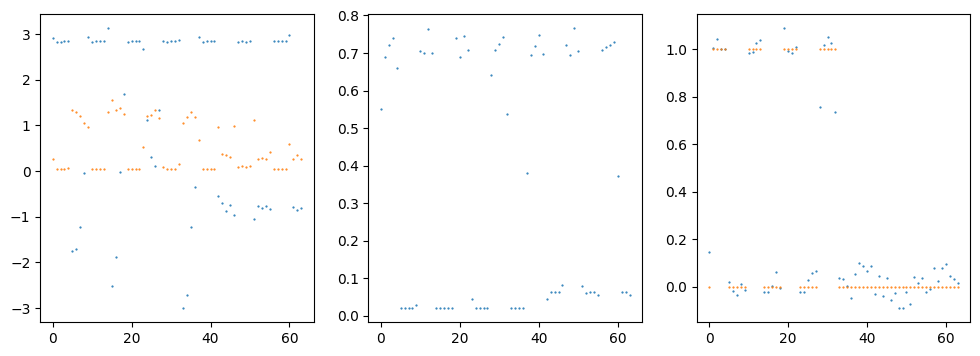

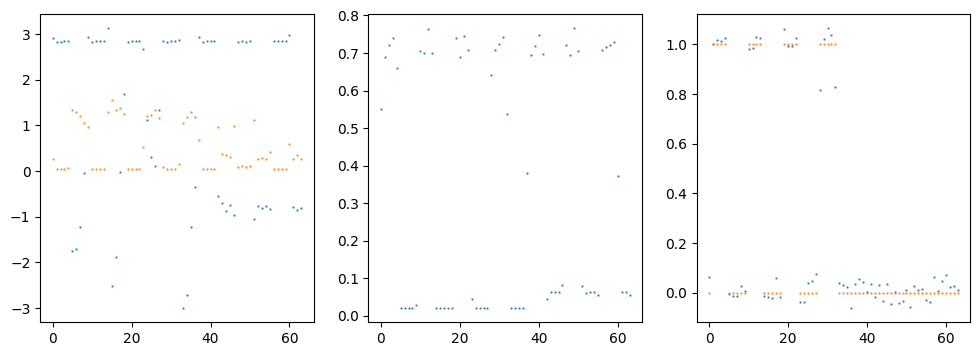

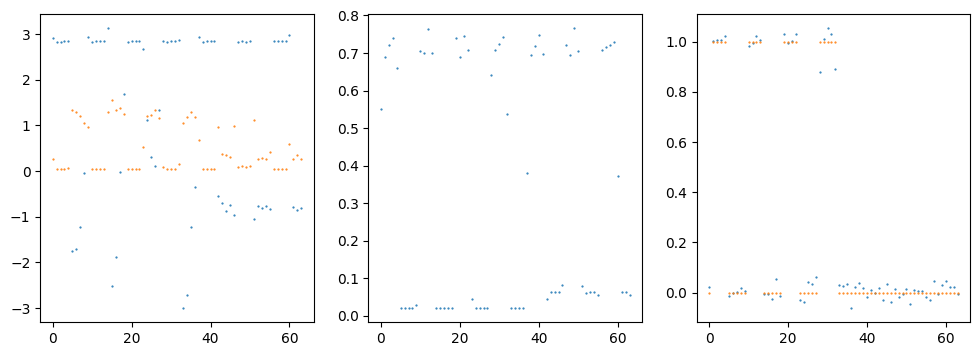

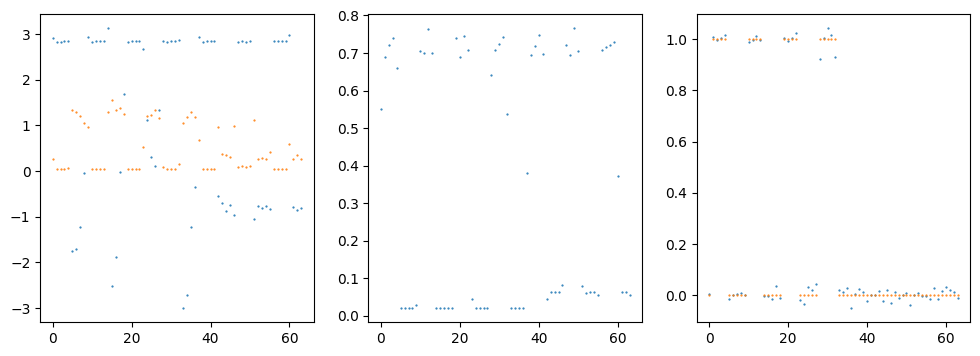

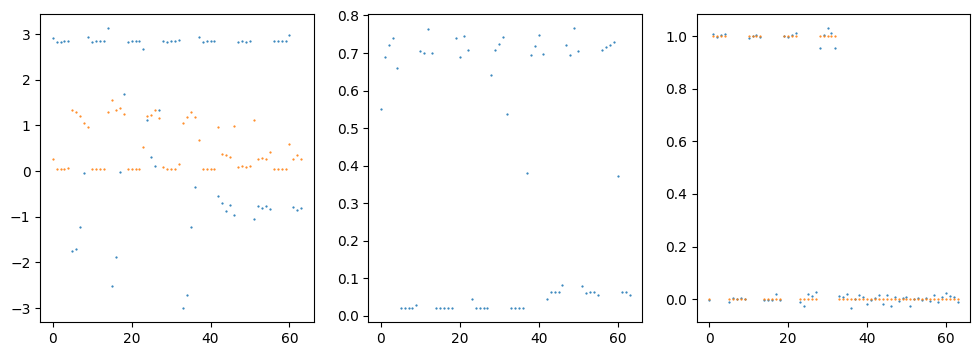

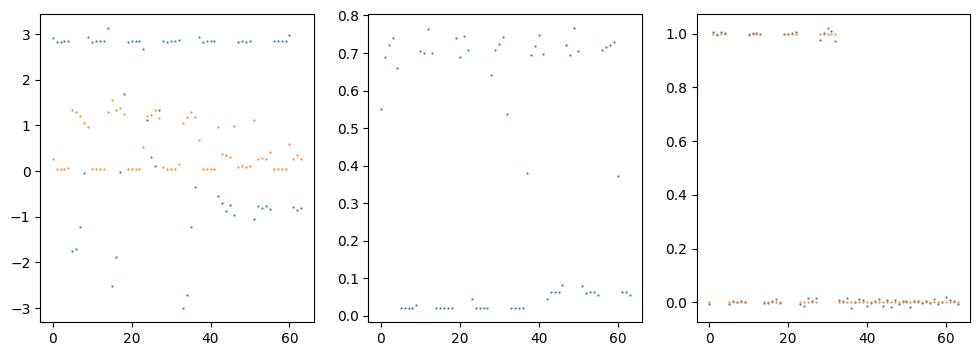

In [26]:
from functools import cache
import gc

from spf.dataset.spf_dataset import v5_collate_beamsegnet, v5_thetas_to_targets
from spf.model_training_and_inference.models.beamsegnet import (
    BeamNSegNetDirect,
    BeamNSegNetDiscrete,
    # BeamNetDirect,
    UNet1D,
    ConvNet,
)

torch_device = torch.device("cpu")
nthetas = 11
lr = 0.001


dataloader_params = {
    "batch_size": 4,
    "shuffle": True,
    "num_workers": 0,
    "collate_fn": v5_collate_beamsegnet,
}
torch.manual_seed(1337)
train_dataloader = torch.utils.data.DataLoader(ds, **dataloader_params)

import wandb
import random


# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="projectspf",
    # track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "architecture": "beamsegnet1",
    },
)


@cache
def mean_guess(shape):
    return torch.nn.functional.normalize(torch.ones(shape), p=1, dim=1)


X, Y_rad, segmentation = next(iter(train_dataloader))


def batch_to_gt_segmentation(X, Y_rad, segmentation):
    n, _, samples_per_session = X.shape
    window_size = 2048
    stride = 2048
    assert window_size == stride
    assert samples_per_session % window_size == 0
    n_windows = samples_per_session // window_size
    window_status = torch.zeros(n, n_windows)
    for row_idx in range(len(segmentation)):
        for window in segmentation[row_idx]["simple_segmentation"]:
            window_status[
                row_idx,
                window["start_idx"] // window_size : window["end_idx"] // window_size,
            ] = 1
    return window_status[:, None]


def segmentation_mask(X, segmentations):
    seg_mask = torch.zeros(
        X.shape[0], X.shape[2], device=X.device
    )  # X.new(X.shape[0], X.shape[2])
    for row_idx in range(seg_mask.shape[0]):
        for w in segmentations[row_idx]["simple_segmentation"]:
            seg_mask[row_idx, w["start_idx"] : w["end_idx"]] = 1
    return seg_mask  # orch.nn.functional.normalize(seg_mask, p=1, dim=1)


# m = BeamNSegNetDiscrete(nthetas=nthetas, symmetry=False).to(torch_device)
# m = BeamNSegNetDirect(nthetas=nthetas, symmetry=False).to(torch_device)
print("ALL", segmentation[0]["all_windows_stats"].shape)
m = UNet1D().to(torch_device).double()
m = ConvNet(in_channels=3, out_channels=1, hidden=32)
optimizer = torch.optim.Adam(m.parameters(), lr=0.00001, weight_decay=0)
step = 0
sigmoid = torch.nn.Sigmoid()
X = X.double().to(torch_device)
# X[:, :2] /= 500
for epoch in range(10000):
    # for X, Y_rad, segmentation in train_dataloader:
    if True:
        optimizer.zero_grad()

        # full
        # downsampled
        input = torch.Tensor(
            np.vstack(
                [
                    segmentation[idx]["all_windows_stats"].transpose()[None]
                    for idx in range(len(segmentation))
                ]
            )
        )
        input[:, 2] /= 50
        # output = sigmoid(m(input)) * 2
        output = m(input)
        seg_mask = batch_to_gt_segmentation(X, Y_rad, segmentation)

        loss = ((output - seg_mask) ** 2).mean()
        loss.backward()
        optimizer.step()

        to_log = {"loss": loss.item()}

        _input = input.cpu()
        _output = output.cpu().detach().numpy()
        first_n = 64

        if step % 1000 == 0:
            print(loss.item())
            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].scatter(range(first_n), _input[0, 0, :first_n], s=0.3)
            axs[0].scatter(range(first_n), _input[0, 1, :first_n], s=0.3)
            axs[1].scatter(range(first_n), _input[0, 2, :first_n], s=0.3)
            # mw = mask_weights.cpu().detach().numpy()

            axs[2].scatter(range(first_n), _output[0, 0, :first_n], s=0.3)
            axs[2].scatter(
                range(first_n), seg_mask.cpu().detach().numpy()[0, 0, :first_n], s=0.3
            )

        wandb.log(to_log)
        step += 1


# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

In [24]:
(output - seg_mask).shape

torch.Size([4, 4, 256])

In [25]:
output.shape, seg_mask.shape

(torch.Size([4, 1, 256]), torch.Size([1, 4, 256]))

In [22]:
from functools import cache
import gc

from spf.dataset.spf_dataset import v5_collate_beamsegnet, v5_thetas_to_targets
from spf.model_training_and_inference.models.beamsegnet import (
    BeamNSegNetDirect,
    BeamNSegNetDiscrete,
    # BeamNetDirect,
    UNet1D,
)

torch_device = torch.device("mps")
nthetas = 11
lr = 0.001


dataloader_params = {
    "batch_size": 4,
    "shuffle": True,
    "num_workers": 2,
    "collate_fn": v5_collate_beamsegnet,
}
torch.manual_seed(1337)
train_dataloader = torch.utils.data.DataLoader(ds, **dataloader_params)

import wandb
import random


# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="projectspf",
    # track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "architecture": "beamsegnet1",
    },
)


@cache
def mean_guess(shape):
    return torch.nn.functional.normalize(torch.ones(shape), p=1, dim=1)


X, Y_rad, segmentation = next(iter(train_dataloader))

# m = BeamNSegNetDiscrete(nthetas=nthetas, symmetry=False).to(torch_device)
m = BeamNSegNetDirect(nthetas=nthetas, symmetry=False).to(torch_device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.0001)
step = 0
for epoch in range(10000):
    # for X, Y_rad in train_dataloader:
    optimizer.zero_grad()
    output = m(X.to(torch_device))
    loss = -m.loglikelihood(output, Y_rad.to(torch_device)).mean()
    loss.backward()
    optimizer.step()

    to_log = {"loss": loss.item()}
    if step % 20 == 0:
        _output = (m.render_discrete_x(output) * 255).cpu().byte()
        _Y = (m.render_discrete_y(Y_rad) * 255).cpu().byte()
        train_target_image = torch.zeros(
            (_output.shape[0] * 2, _output.shape[1]),
        ).byte()
        for row_idx in range(_output.shape[0]):
            train_target_image[row_idx * 2] = _output[row_idx]
            train_target_image[row_idx * 2 + 1] = _Y[row_idx]
        output_image = wandb.Image(
            train_target_image, caption="train vs target (interleaved)"
        )
        to_log["output"] = output_image
    wandb.log(to_log)
    step += 1


# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

KeyboardInterrupt: 

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: csmisko (projectspf). Use `wandb login --relogin` to force relogin


KeyboardInterrupt: 

In [23]:
segmentation[0]["all_windows_stats"].shape

(256, 3)

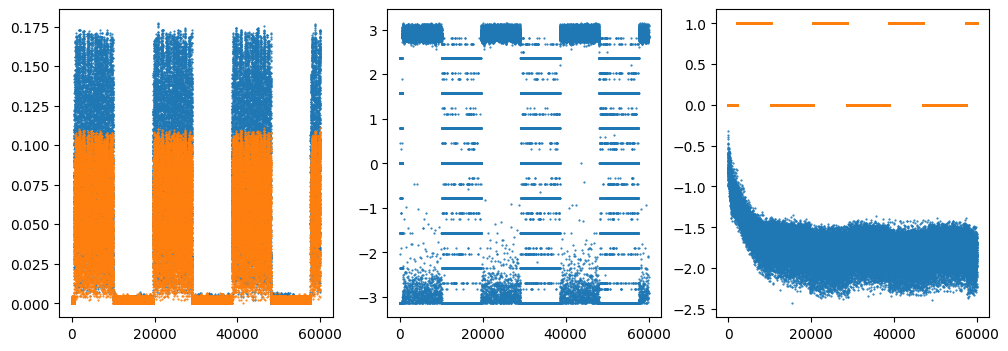

In [60]:
segmentation_mask(X, segmentation)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [61]:
m(X)

tensor([[[-0.2510, -0.1108, -0.3952,  ..., -0.2540, -0.0721, -0.2517]],

        [[-0.1883, -0.0653, -0.4722,  ..., -0.5109, -0.5380, -0.5810]],

        [[ 0.2601,  0.2860, -0.3667,  ..., -0.1230, -0.2176, -0.2918]],

        [[-0.1958,  0.0429, -0.3129,  ..., -0.4326, -0.6186, -0.6577]]],
       dtype=torch.float64, grad_fn=<ConvolutionBackward0>)

In [62]:
_X = X.clone().to(torch_device)
_X[:, :2] /= 500
batch_size, input_channels, session_size = _X.shape
beam_former_input = _X.transpose(1, 2).reshape(
    batch_size * session_size, input_channels
)
print(_X.device, beam_former_input)
beam_former = m.beam_net(beam_former_input).reshape(
    batch_size, session_size, 5  # mu, o1, o2, k1, k2
)
mask_weights = m.softmax(m.unet1d(_X)[:, 0])

cpu tensor([[ 2.0000e-03,  2.0000e-03,  0.0000e+00],
        [ 0.0000e+00,  2.8284e-03,  2.3562e+00],
        [ 0.0000e+00,  2.0000e-03, -3.1416e+00],
        ...,
        [ 1.8404e-01,  9.9639e-02, -2.4917e+00],
        [ 1.8248e-01,  9.9298e-02, -2.4948e+00],
        [ 1.7819e-01,  9.5037e-02, -2.5040e+00]], dtype=torch.float64)


AttributeError: 'UNet1D' object has no attribute 'beam_net'

In [23]:
beam_former_input

tensor([[ 0.0540,  0.0247, -1.8528],
        [ 0.0560,  0.0247, -1.8515],
        [ 0.0600,  0.0247, -1.8491],
        ...,
        [ 0.0028,  0.0028, -0.0000],
        [ 0.0028,  0.0020,  0.7854],
        [ 0.0028,  0.0028, -0.0000]], device='mps:0')

In [24]:
ds[0]

{'system_timestamp': tensor([0.5491]),
 'tx_pos_x_mm': tensor([1523.5000]),
 'tx_pos_y_mm': tensor([852.9000]),
 'rx_pos_x_mm': tensor([2623.2000]),
 'rx_pos_y_mm': tensor([2669.8999]),
 'rx_theta_in_pis': tensor([-0.2500]),
 'rx_spacing': tensor([0.0507]),
 'rx_lo': tensor([2.4120e+09]),
 'rx_bandwidth': tensor([300000.]),
 'avg_phase_diff': tensor([-2.3098, -2.4246], dtype=torch.float64),
 'rssis': tensor([79.7500, 89.2500], dtype=torch.float64),
 'gains': tensor([56., 40.], dtype=torch.float64),
 'signal_matrix': tensor([[-585.+460.j, -603.+460.j, -617.+457.j,  ...,  -15.+5.j,  -14.+4.j,
           -13.+4.j],
         [   5.-48.j,   -5.-52.j,  -16.-55.j,  ...,    2.-3.j,    4.-3.j,
             4.-3.j]], dtype=torch.complex128),
 'ground_truth_theta': tensor([-1.8119]),
 'x': tensor([[[ 48.2597,  52.2398,  57.2800,  ...,   3.6056,   5.0000,   5.0000],
          [744.1942, 758.4254, 767.8138,  ...,  15.8114,  14.5602,  13.6015],
          [  2.3409,   2.1266,   1.9252,  ...,   2.4805

In [52]:
seg_mask.sum(axis=1)

tensor([1., 1., 1., 1.], device='mps:0')

In [51]:
seg_mask.cpu().detach().numpy()[0].sum()

0.116866454

wandb: Network error (ConnectTimeout), entering retry loop.


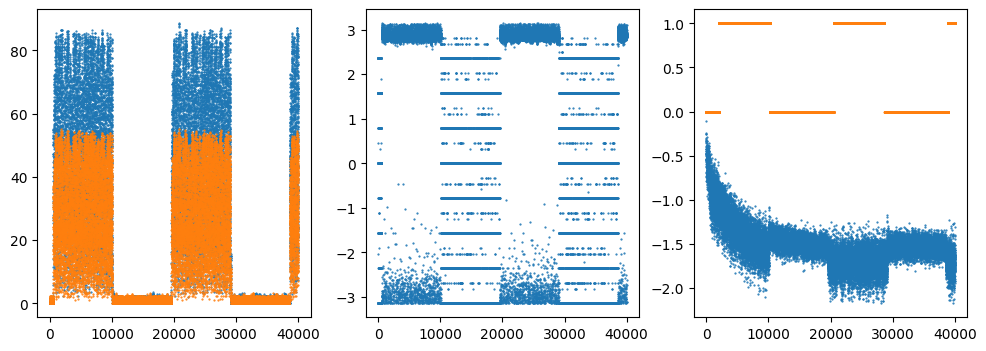

In [64]:
first_n = 40000
x = X[0].cpu()

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].scatter(range(first_n), x[0, :first_n], s=0.3)
axs[0].scatter(range(first_n), x[1, :first_n], s=0.3)
axs[1].scatter(range(first_n), x[2, :first_n], s=0.3)
# mw = mask_weights.cpu().detach().numpy()
mw = m(X).cpu().detach().numpy()[0]
axs[2].scatter(range(first_n), mw[0, :first_n], s=0.3)
axs[2].scatter(range(first_n), seg_mask.cpu().detach().numpy()[0, :first_n], s=0.3)

In [30]:
mask_weights[0]

tensor([2.1336e-06, 2.1451e-06, 2.0366e-06,  ..., 1.9234e-06, 1.8966e-06,
        1.9372e-06], device='mps:0', grad_fn=<SelectBackward0>)

In [ ]:
from spf.model_training_and_inference.models.beamsegnet import BeamNSegNetDirect


m = BeamNSegNetDirect(nthetas=nthetas)

optimizer = torch.optim.AdamW(m.parameters(), lr=0.01)

m.beam_net.beam_net[0].weight.grad

In [24]:
x, y = next(iter(train_dataloader))

In [35]:
k = x[[0]]
k_y = y[[0]]
k[:, 2] = -k[:, 2].sign() * k[:, 2]
# k[:, 2] = k[:, 2].sign() * k[:, 2]

In [36]:
k[:, 2]

tensor([[-2.0344, -0.7854, -2.6779,  ..., -0.3897, -0.3840, -0.3681]])

In [37]:
optimizer.zero_grad()
m.train()
m.beam_net.beam_net[0].weight.grad

In [24]:
X.max()

tensor(210.7937)

In [38]:
output = m(k)

loss_fn = torch.nn.MSELoss()
l = loss_fn(output, k_y)
l.backward()
# mean_loss = output
# optimizer.step()

In [40]:
output

tensor([[-0.0848,  1.5203,  1.4942,  0.4164,  0.5655]], grad_fn=<SumBackward1>)

In [39]:
m.beam_net.beam_net[0].weight.grad

tensor([[-3.0647e-04, -3.6151e-04,  2.8559e-05],
        [-1.8807e-03, -6.3968e-03, -3.8365e-04],
        [ 8.5217e-03,  3.4519e-03, -8.9635e-07],
        [-1.5145e-03,  5.9680e-04,  7.2089e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.6874e-02,  1.5181e-02,  3.3470e-03],
        [ 2.0060e-04,  8.6125e-04,  1.3004e-05],
        [ 1.5097e-04, -3.3788e-04, -3.3574e-04],
        [-7.6383e-02, -1.7484e-02, -6.5846e-04],
        [ 3.1269e-03, -5.4818e-02,  2.5365e-02],
        [ 5.3106e-04,  9.0006e-04,  1.3157e-04],
        [ 5.2094e-03,  3.1029e-02,  7.3642e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-2.5641e-04,  3.0116e-04, -3.9027e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]])

In [ ]:
plt.imshow(Y.to("cpu"))